<center>
<img src="http://www.gonella.biz/assets/consel.jpg">
</center>

## Import libraries

In [48]:
%pylab inline
import pandas as pd
import numpy as np
from numpy import concatenate
from sklearn import metrics, preprocessing
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn import grid_search
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Import data

####Import loans

#### Import geo IP e CAP Residenza e Datore Lavoro

In [2]:
sella = pd.read_csv('../data/Sample_consel.csv', sep=';', quotechar="'")  
sella.shape

(24110, 60)

In [3]:
sella_cap_ip = pd.read_csv('../data/geolocalized_loans.csv', sep=',')
sella_cap_ip.shape

(24110, 15)

In [4]:
sella_cap_ip = sella_cap_ip.ix[:,['LOAN_NUMBER','IP_COUNTRY','IP_EQ_RES','EMP_EQ_RES','IP_EQ_EMP']]

In [5]:
sella_cap_ip.shape

(24110, 5)

####Merge dataframe

In [6]:
sella = pd.merge(sella, sella_cap_ip, how ='left', on='LOAN_NUMBER')

In [7]:
sella.shape

(24110, 64)

## Clean data

####Remove duplicates

In [8]:
sella = sella.drop_duplicates("LOAN_NUMBER")  

####Set contract_number as index 

In [47]:
sella = sella.set_index('LOAN_NUMBER')

####Drop rejected & retried loans

In [9]:
sella = sella[sella.LOAN_STATE != 'REJECT_LOAN']
sella = sella[sella.LOAN_STATE != 'RETRAED_LOAN']

####Count missing values

In [10]:
sella.isnull().sum()

DEFAULT                       0
DEFAULT_AMOUNT                0
LOAN_AMOUNT                   0
LOAN_INSTALMENT_AMOUNT        0
LOAN_NUMBER                   0
LOAN_NUMBER_OF_INSTALMENTS    0
LOAN_RATING                   0
LOAN_STATE                    0
LOAN_IRREGULARITY             0
LOAN_SYSTEM_ACCEPT            0
LOAN_SYSTEM_REJECT            0
LOAN_DATE                     0
ALERT_14                      0
ALERT_15                      0
ALERT_46                      0
...
CUSTOMER_EMPLOYER_PHONE_NUMBER     2203
CUSTOMER_EMPLOYER_CAP_CODE            0
RULE_EMAIL_OTHER_CONTRACT             0
RULE_NOT_REGISTERED_FOREIGN           0
RULE_TELEF_DOC_ALTRA_PRT              0
T_CREDIT_CARD_GRANTED                 0
T_CREDIT_CARD_EXTINCT                 0
T_CREDIT_CARD_REJECTED               13
T_NR_RESIDENCE                        0
T_PERFORM                            97
T_NOTIFICATION                        0
IP_COUNTRY                         7077
IP_EQ_RES                         12

## Features Engineering

####Add transactions counter by Customer Code

In [11]:
sella['count'] = sella.groupby(['CUSTOMER_CODE'])['CUSTOMER_CODE'].transform('count').astype('int')

sella['CUSTOMER_STATUS'] = 0
sella['CUSTOMER_STATUS'][sella['count']>3] = 1

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


####Extract day of the week

In [12]:
import datetime

sella['LOAN_DATE'] = np.array([datetime.datetime.strptime(x, "%Y-%m-%d").date() for x in sella['LOAN_DATE']])
sella['WEEKDAY'] = sella.LOAN_DATE.apply(lambda x: x.isoweekday())

####Aggregate Mails Info

In [13]:
sella['CUSTOMER_EMAIL'] = sella['CUSTOMER_EMAIL'].apply(lambda x: str(x).split(" ")[0])

sella['EMAIL_TLD'] = sella['CUSTOMER_EMAIL'].apply(lambda x: str(x).split(".")[-1])
sella['EMAIL_SLD'] = sella['CUSTOMER_EMAIL'].apply(lambda x: str(x).rsplit(".",1)[0])

sella['EMAIL_TLD_STATUS'] = 'NaN'

# gruppo mail da dominio italiano
sella['EMAIL_TLD_STATUS'][sella.EMAIL_TLD=="it"] = 'ita'

# gruppo mail da dominio generico
sella['EMAIL_TLD_STATUS'][sella.EMAIL_TLD.isin(['com','org','net','biz','eu','info','tv'])]= 'gen'

# gruppo mail da dominio straniero
sella['EMAIL_TLD_STATUS'][sella.EMAIL_TLD.isin(['uk', 'pl', 'ro', 'es', 'fr', 'lv', 'br',  
                                                'ie', 'ru', 'hu', 'dk', 'de', 'ch', 'ca', 'co', 'bg', 'edu'])] ='str'

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
# raggruppo mail che non sono provider di posta
sella['EMAIL_SLD_STATUS'] = sella['EMAIL_SLD']

sella['EMAIL_SLD_STATUS'][~sella.EMAIL_SLD.isin(['gmail','libero','hotmail','alice','yahoo','tiscali','virgilio',
                                                'live','tin','fastwebnet','inwind', 'email', 'vodafone','me',
                                               'icloud','msn','teletu','outlook','katamail','ymail','poste', 
                                                'telecomitalia', 'iol','interfree','tiscalinet','infinito',
                                                'istruzione','excite','ngi','pec','fastwebmail','aruba',
                                               'aliceposta','rocketmail','googlemail','mail','yahoo.co','tim',
                                               'gmx'])]= 'pri'

sella['EMAIL_SLD_STATUS'][sella['EMAIL_SLD']=='nan'] = 'NaN'

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


###IP not in Italy

In [15]:
sella['COUNTRY_IP'] = 'NaN'
sella['COUNTRY_IP'][sella['IP_COUNTRY']=='Italy']= 'Italy'
sella['COUNTRY_IP'][sella.IP_COUNTRY.isin(['France','Brazil','Germany','Switzerland','Tunisia','United States',
                                       'Netherlands','China','Slovenia','United Kingdom','Republic of the Congo',
                                       'Morocco','Romania','Qatar'])]= 'Abroad'

sella['COUNTRY_IP'].unique()

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


array(['Italy', 'NaN', 'Abroad'], dtype=object)

####IP Provincia Not in Residence Provincia

In [16]:
sella['IP_EQ_RES'].unique()  

array([nan, False, True], dtype=object)

#### Employer Residence Not in Customer Residence Provincia

In [17]:
sella['EMP_EQ_RES'].unique()

array([True, nan, False], dtype=object)

#### IP Not in Employer Provincia

In [18]:
sella['IP_EQ_EMP'].unique()

array([nan, False, True], dtype=object)

##Customer Phone Operator

In [19]:
tim = list(map(str, (330, 331, 333, 334, 335, 336, 337, 338, 339, 360, 361, 362, 363, 366, 368, 385)))
vodafone = list(map(str, (340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 383)))
wind = list(map(str, (320, 322, 323, 324, 327, 328, 329, 380, 383, 388, 389)))
tre = list(map(str, (390, 391, 392, 393, 397)))
big4 = tim+vodafone+wind+tre

In [20]:
def phone_operator(digits):
    digits = str(digits)
    if digits=='nan': return None
    if digits[0]=='3':
        if digits[:3] in big4:
            return "mobile_big"
        else:
            return "mobile_strange"
    else:
        return "fixed"
sella['CUSTOMER_PHONE_OPERATOR'] = sella.CUSTOMER_PHONE_NUMBER.apply(phone_operator)

### T_perform missing --> metto = 0 

In [21]:
sella['T_PERFORM'][sella['T_PERFORM'].isnull()] = 0

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## Convert feature formatting

####Drop unmeaningful variables

In [22]:
sella.drop('DEFAULT_AMOUNT', axis=1, inplace=True)
sella.drop('LOAN_STATE', axis=1, inplace=True)
sella.drop('count', axis=1, inplace=True)
sella.drop('EMAIL_SLD', axis=1, inplace=True)
sella.drop('EMAIL_TLD', axis=1, inplace=True) 

####Formatting

In [23]:
from sklearn.preprocessing import LabelEncoder  

Telephone_ix= ['ALERT_14','ALERT_15','ALERT_61','ALERT_77','ALERT_88','ALERT_93','ALERT_94'] 
Past_ix = ['ALERT_64','ALERT_69','ALERT_72','ALERT_84','ALERT_92','RULE_TELEF_DOC_ALTRA_PRT']
Adress_ix = ['ALERT_55','ALERT_62','ALERT_74','ALERT_87','ALERT_90','ALERT_91'] 
Loan_ix = ['LOAN_AMOUNT'] 
Notification_ix = ['T_NOTIFICATION']
Rating_ix = ['T_PERFORM']
Customer_status_ix = ['CUSTOMER_STATUS']
Week_ix = ['WEEKDAY']
New_ix = ['EMAIL_TLD_STATUS','EMAIL_SLD_STATUS','COUNTRY_IP','CUSTOMER_PHONE_OPERATOR','IP_EQ_RES',
          'EMP_EQ_RES','IP_EQ_EMP', 'CUSTOMER_EMPLOY', 'CUSTOMER_NATIONALITY_AREA', 'T_CREDIT_CARD_GRANTED ',
          'T_CREDIT_CARD_EXTINCT']

for b in Telephone_ix + Adress_ix + Notification_ix + Rating_ix + Customer_status_ix + Past_ix :
    sella[b] = sella[b].astype("int_")

for b in Loan_ix:
    sella[b] = sella[b].astype("float_")
    
for b in Week_ix:
    sella[b] = sella[b].astype("category")
    
for b in New_ix:
    sella[b] = LabelEncoder().fit_transform(sella[b])

## Get labels y and features X

In [24]:
sella_clean = sella;

y = sella_clean["DEFAULT"] 
X = sella_clean.ix[:, Loan_ix+Telephone_ix+Adress_ix+ Past_ix+ Notification_ix + Rating_ix + 
                   Customer_status_ix+Week_ix]  #New_ix

X.head()

LOAN_AMOUNT  ALERT_14  ALERT_15  ALERT_61  ALERT_77  ALERT_88  ALERT_93  \
0          610         0         0         0         0         0         0   
1         1001         0         0         0         0         0         1   
2          212         0         0         0         1         0         0   
3          385         0         0         1         0         1         0   
4          739         0         0         0         1         1         0   

   ALERT_94  ALERT_55  ALERT_62   ...     ALERT_64  ALERT_69  ALERT_72  \
0         0         0         0   ...            0         0         0   
1         0         0         0   ...            0         0         0   
2         0         0         0   ...            0         0         0   
3         0         0         0   ...            0         0         0   
4         1         0         0   ...            0         0         0   

   ALERT_84  ALERT_92  RULE_TELEF_DOC_ALTRA_PRT  T_NOTIFICATION  T_PERFORM  \
0         0         0                         0               1        565   
1         0         0                         0               0        478   
2         0         0                         0               5        520   
3         0         0                         0               3        531   
4         1         1                         0               5        571   

   CUSTOMER_STATUS  WEEKDAY  
0                0        2  
1                0        5  
2                0        7  
3                0        5  
4                0        4  

[5 rows x 24 columns]

##GRID SEARCH

In [31]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=0, class_weight = 'auto')

param_grid = {'n_estimators': np.arange(40,160, step = 10), 'max_depth': np.arange(3,9, step=1)}
gs = grid_search.GridSearchCV(model,  param_grid = param_grid, cv=StratifiedKFold(y, 10,shuffle=True), scoring='roc_auc')
gs.fit(X,y)

print gs.best_params_ , gs.best_score_

n_estimators_param = gs.best_params_["n_estimators"]  #100
max_depth_param = gs.best_params_["max_depth"]   #5

{'n_estimators': 100, 'max_depth': 5} 0.878079811463


## Cross validation

In [32]:
# Set reproducible seed
random.seed([5])

# Weighted Random Forest Classifier - Stratified samples
model_opt = RandomForestClassifier(random_state=0, n_estimators=n_estimators_param, max_depth=max_depth_param,
                                   class_weight = 'auto')
# Cross-validation and metrics
fraud_proba =[]
cv_T = np.zeros([2,2], dtype="int")
feature_importance = np.zeros([X.shape[1]])
recalls = []
roc = []

for train_index, test_index in cross_validation.StratifiedKFold(list(y.values), 221, shuffle=True):
    model_opt.fit(X.iloc[train_index], y.iloc[train_index])
    predictions = model_opt.predict(X.iloc[test_index])
    predict_prob = [i[1] for i in model_opt.predict_proba(X.iloc[test_index])]
    
    cv        = metrics.confusion_matrix(y.iloc[test_index],predictions)
    cv_T += cv
    
    recalls.append(metrics.recall_score(y.iloc[test_index],predictions))
    roc.append(metrics.roc_auc_score(y.iloc[test_index],predict_prob, average = None))

    feature_importance += model_opt.feature_importances_
    
recall_T = np.mean(recalls)
roc_T = np.mean(roc)

print "Confusion Matrix: "
print cv_T 
print "Recall Metrics: ",recall_T
print "Roc-Auc Curve: ", roc_T

Confusion Matrix: 
[[16758  2330]
 [   60   161]]
Recall Metrics:  0.72850678733
Roc-Auc Curve:  0.872327673899


Confusion Matrix: 
[[16758  2330]
 [   60   161]]
 
Recall Metrics:  0.72850678733
Roc-Auc Curve:  0.872327673899

## Feature Importance

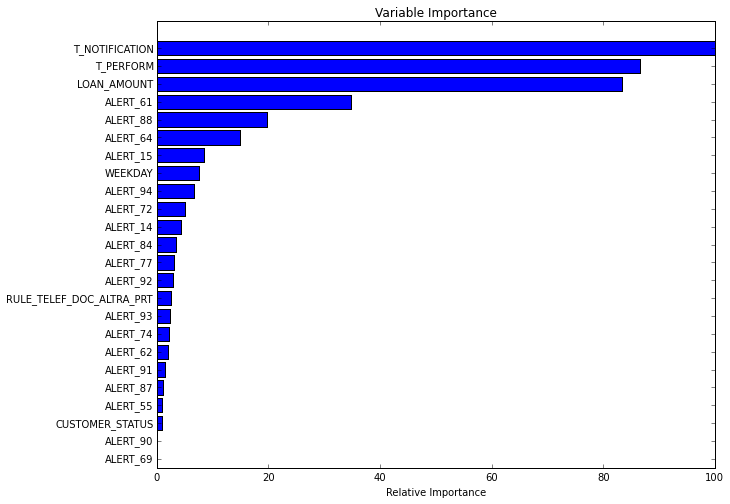

In [33]:
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

#Plot
plt.figure(figsize=(10,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns.values)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Test Set

### Predict on Test Set

In [25]:
random.seed([5])

fraud_proba =[]
cv_T = np.zeros([2,2], dtype="int")
feature_importance = np.zeros([X.shape[1]])
recalls = []
roc = []


for train_index, test_index in cross_validation.StratifiedKFold(list(y.values), 3, shuffle=True):
    model_opt.fit(X.iloc[train_index], y.iloc[train_index])
    predictions = model_opt.predict(X.iloc[test_index])
    predict_prob = [i[1] for i in model_opt.predict_proba(X.iloc[test_index])]
    
    cv        = metrics.confusion_matrix(y.iloc[test_index],predictions)
    cv_T += cv
    
    recalls.append(metrics.recall_score(y.iloc[test_index],predictions))
    roc.append(metrics.roc_auc_score(y.iloc[test_index],predict_prob, average = None))

    feature_importance += model_opt.feature_importances_
    break

NameError: name 'model_opt' is not defined

In [28]:
# Weighted Random Forest Classifier - Stratified samples4
n_estimators_param=100
max_depth_param=5
model_opt = RandomForestClassifier(random_state=0, n_estimators=n_estimators_param, max_depth=max_depth_param,
                                   class_weight = 'auto')
model_opt.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [85]:
sella = pd.read_csv('../data/Sample_consel.csv', sep=';', quotechar="'")  
sella.shape

(24110, 60)

In [95]:
len(sella)-14573-279

9258

In [100]:
sella.LOAN_STATE

0     FINANCED_LOAN
1     FINANCED_LOAN
2     FINANCED_LOAN
3     FINANCED_LOAN
4     FINANCED_LOAN
5      RETRAED_LOAN
6     FINANCED_LOAN
7     FINANCED_LOAN
8     FINANCED_LOAN
9     FINANCED_LOAN
10      REJECT_LOAN
11      REJECT_LOAN
12     RETRAED_LOAN
13    FINANCED_LOAN
14     RETRAED_LOAN
...
24095    FINANCED_LOAN
24096    FINANCED_LOAN
24097    FINANCED_LOAN
24098    FINANCED_LOAN
24099    FINANCED_LOAN
24100    FINANCED_LOAN
24101    FINANCED_LOAN
24102    FINANCED_LOAN
24103    FINANCED_LOAN
24104    FINANCED_LOAN
24105    FINANCED_LOAN
24106    FINANCED_LOAN
24107    FINANCED_LOAN
24108    FINANCED_LOAN
24109     RETRAED_LOAN
Name: LOAN_STATE, Length: 24110, dtype: object

In [99]:
sella[sella.LOAN_SYSTEM_ACCEPT ==False][sella.LOAN_SYSTEM_REJECT ==False][sella.LOAN_SYSTEM_REJECT ==False].value_counts()

0    9144
1     114
dtype: int64

In [69]:
sella['count'] = sella.groupby(['CUSTOMER_CODE'])['CUSTOMER_CODE'].transform('count').astype('int')

sella['CUSTOMER_STATUS'] = 0
sella['CUSTOMER_STATUS'][sella['count']>3] = 1

import datetime

sella['LOAN_DATE'] = np.array([datetime.datetime.strptime(x, "%Y-%m-%d").date() for x in sella['LOAN_DATE']])
sella['WEEKDAY'] = sella.LOAN_DATE.apply(lambda x: x.isoweekday())

sella['T_PERFORM'][sella['T_PERFORM'].isnull()] = 0

In [70]:
sella = sella.drop_duplicates("LOAN_NUMBER")  

In [71]:
sella = sella.set_index('LOAN_NUMBER')

In [72]:
sella.LOAN_STATE.unique()

array(['FINANCED_LOAN', 'RETRAED_LOAN', 'REJECT_LOAN'], dtype=object)

In [73]:
sella = sella[sella.LOAN_STATE != 'FINANCED_LOAN']

In [74]:
sella_clean = sella;

y = sella_clean["DEFAULT"] 
X = sella_clean.ix[:, Loan_ix+Telephone_ix+Adress_ix+ Past_ix+ Notification_ix + Rating_ix + 
                   Customer_status_ix+Week_ix]

In [75]:
sella_clean.isnull().sum()

DEFAULT                       0
DEFAULT_AMOUNT                0
LOAN_AMOUNT                   0
LOAN_INSTALMENT_AMOUNT        0
LOAN_NUMBER_OF_INSTALMENTS    0
LOAN_RATING                   0
LOAN_STATE                    0
LOAN_IRREGULARITY             0
LOAN_SYSTEM_ACCEPT            0
LOAN_SYSTEM_REJECT            0
LOAN_DATE                     0
ALERT_14                      0
ALERT_15                      0
ALERT_46                      0
ALERT_55                      0
...
CUSTOMER_EMPLOYER_COUNTRY_RESIDENCE    768
CUSTOMER_EMPLOYER_PHONE_NUMBER         715
CUSTOMER_EMPLOYER_CAP_CODE               0
RULE_EMAIL_OTHER_CONTRACT                0
RULE_NOT_REGISTERED_FOREIGN              0
RULE_TELEF_DOC_ALTRA_PRT                 0
T_CREDIT_CARD_GRANTED                    0
T_CREDIT_CARD_EXTINCT                    0
T_CREDIT_CARD_REJECTED                   4
T_NR_RESIDENCE                           0
T_PERFORM                                0
T_NOTIFICATION                           0


In [79]:
# predicted = [i[1] for i in model_opt.predict_proba(X)]
predicted = model_opt.predict(X)

In [84]:
sum(sella_clean.LOAN_SYSTEM_REJECT.values)

279

In [83]:
metrics.confusion_matrix(predicted, sella_clean.LOAN_SYSTEM_REJECT.values)

array([[3523,  154],
       [ 999,  125]])

### Print Probability Threasholds with their confusion matrix

In [35]:
(np.array(predict_prob) > 0.4).astype(int)  # Individual Probability greater than 0.4

array([1, 0, 0, ..., 0, 0, 1])

In [37]:
for soglia in np.arange(0,1,.1):
    print soglia
    print metrics.confusion_matrix(y.iloc[test_index], np.array(predict_prob) > soglia)

0.0
[[   0 6363]
 [   0   74]]
0.1
[[ 391 5972]
 [   0   74]]
0.2
[[2148 4215]
 [   4   70]]
0.3
[[3848 2515]
 [   9   65]]
0.4
[[4987 1376]
 [  13   61]]
0.5
[[5721  642]
 [  27   47]]
0.6
[[6035  328]
 [  35   39]]
0.7
[[6212  151]
 [  54   20]]
0.8
[[6300   63]
 [  64   10]]
0.9
[[6363    0]
 [  74    0]]


### Look at those fraudes ML detects that are not rejected from Consel System

In [38]:
sella.iloc[test_index[np.array(predict_prob) > 0.4]][(sella.LOAN_SYSTEM_ACCEPT==True) & (sella.DEFAULT ==True)]

/usr/lib/python2.7/dist-packages/pandas/core/frame.py:1771: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


DEFAULT  LOAN_AMOUNT  LOAN_INSTALMENT_AMOUNT  \
LOAN_NUMBER                                                 
2835085            1         1011                     101   
2877980            1          882                      25   
2774779            1          929                     165   
2773055            1          230                      20   
2773737            1          990                      39   
2777784            1          997                      28   
2780782            1          970                      38   
2783459            1          998                      36   
2791053            1          770                      30   
2797954            1          914                      86   
2807233            1         1686                      57   
2812787            1          852                      35   
2824924            1          659                      62   
2834024            1          847                      26   
2886527            1         1900                     123   
2890906            1          800                      22   
2906256            1          416                      69   
2912539            1          868                      33   
2929905            1          748                      76   
2942332            1          738                      20   
2953951            1          991                      31   
2987630            1         4257                     151   
3053021            1          940                      86   
3053776            1         1708                      82   
3060943            1         1682                     102   
3079799            1          828                      51   
3087354            1          457                      41   

             LOAN_NUMBER_OF_INSTALMENTS  LOAN_RATING  \
LOAN_NUMBER                                            
2835085                              11            5   
2877980                              48            6   
2774779                               6            9   
2773055                              12            5   
2773737                              30            5   
2777784                              48            7   
2780782                              30            4   
2783459                              36            5   
2791053                              30            5   
2797954                              12            5   
2807233                              36            5   
2812787                              30            5   
2824924                              12            5   
2834024                              42            4   
2886527                              18            5   
2890906                              48            5   
2906256                               6            9   
2912539                              30            4   
2929905                              10            7   
2942332                              48            4   
2953951                              42            4   
2987630                              30            7   
3053021                              12            6   
3053776                              24            8   
3060943                              18            7   
3079799                              18            6   
3087354                              12            5   

                                          LOAN_IRREGULARITY  \
LOAN_NUMBER                                                   
2835085                                        Nessuna nota   
2877980                                        Nessuna nota   
2774779                                        Nessuna nota   
2773055                                        Nessuna nota   
2773737                                        Nessuna nota   
2777784                                        Nessuna nota   
2780782                                        Nessuna nota   
2783459                                        Ness

50% of the fraudes detected by our model were automatically accepted by Consel Systems

#### EXPORT INDIVIDUAL PROBABILITY CSV

In [80]:
with open("model_0.1.tsv", 'w') as f:
    print >>f, "trees: 90, depth: 5, variabili: basic, feature-selection: no, folds 3"
    for loan_number, probability in zip(sella_clean.index[test_index], predict_prob):
        print >>f, loan_number, probability